# Dataset Exploration

## Setup and Configuration

In [1]:
import os
import torch
import textwrap
import numpy as np
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.lines import Line2D
from ogb.nodeproppred import NodePropPredDataset

import warnings
warnings.filterwarnings("ignore", module='outdated')
warnings.filterwarnings("ignore", message=".*weights_only=False.*")

c:\Users\Tulio\AppData\Local\Programs\Python\Python311\Lib\site-packages\outdated\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
data_dir = '../dataset' # Relative path from the project root
ogb_root = os.path.join(data_dir, 'ogbn_arxiv')

# Ensure the 'dataset' directory exists
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Directory '{data_dir}' created.")

## Load Dataset

In [3]:
dataset = NodePropPredDataset(name='ogbn-arxiv', root=data_dir)

In [4]:
# Extract graph, labels, and splits
graph, labels = dataset[0]
node_features = graph['node_feat'] # Node features
num_nodes = graph['num_nodes']
edge_index = graph['edge_index']
num_edges = edge_index.shape[1]

In [5]:
split_idx = dataset.get_idx_split()

train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx = split_idx["test"]

In [6]:
print(f"\n--- Dataset Splits ---")
print(f"Train (up to 2017): {len(train_idx)} nodes")
print(f"Validation (2018): {len(valid_idx)} nodes")
print(f"Test (2019+): {len(test_idx)} nodes")


--- Dataset Splits ---
Train (up to 2017): 90941 nodes
Validation (2018): 29799 nodes
Test (2019+): 48603 nodes


## Load Mapping Files

In [7]:
# Load category mapping (label index to category name)
label_map_path = os.path.join(ogb_root, 'mapping', 'labelidx2arxivcategeory.csv.gz')
label_map_df = pd.read_csv(label_map_path, compression='gzip', skiprows=1, header=None, names=['label_idx', 'category_name'])
label_map = dict(zip(label_map_df.label_idx, label_map_df.category_name))
list(label_map.items())[:5]

[(0, 'arxiv cs na'),
 (1, 'arxiv cs mm'),
 (2, 'arxiv cs lo'),
 (3, 'arxiv cs cy'),
 (4, 'arxiv cs cr')]

In [8]:
# Load node index to paper ID mapping
node_map_path = os.path.join(ogb_root, 'mapping', 'nodeidx2paperid.csv.gz')
node_map_df = pd.read_csv(node_map_path, compression='gzip', skiprows=1, header=None, names=['node_idx', 'paper_id'])
node2paperid = dict(zip(node_map_df.node_idx, node_map_df.paper_id))
list(node2paperid.items())[:5]

[(0, 9657784), (1, 39886162), (2, 116214155), (3, 121432379), (4, 231147053)]

In [9]:
# Load paper ID to title/abstract mapping
titleabs_path = os.path.join(ogb_root, 'titleabs.tsv')
titleabs_df = pd.read_csv(titleabs_path, sep='\t', header=None, names=['paper_id', 'title', 'abstract'])
paperid2title = dict(zip(titleabs_df.paper_id, titleabs_df.title))
list(paperid2title.items())[:5]

[(200971, 'ontology as a source for rule generation'),
 (549074,
  'a novel methodology for thermal analysis a 3 dimensional memory integration'),
 (630234, 'spreadsheets on the move an evaluation of mobile spreadsheets'),
 (803423, 'multi view metric learning for multi view video summarization'),
 (1102481, 'big data analytics in future internet of things')]

## Exploratory Graph Analysis

In [10]:
print(f"Number of categories: {len(label_map.values())}")

Number of categories: 40


In [11]:
# Number of nodes and edges
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Feature dimensions: {node_features.shape}")
print(f"Label dimensions: {labels.shape}")

Number of nodes: 169343
Number of edges: 1166243
Feature dimensions: (169343, 128)
Label dimensions: (169343, 1)


In [12]:
# Label distribution with category names
print("\nLabel Distribution:")
unique_labels, counts = np.unique(labels, return_counts=True)
# Map label indices to names for printing and plotting
named_counts = {label_map[label]: count for label, count in zip(unique_labels, counts)}
sorted_named_labels = sorted(named_counts.items(), key=lambda item: item[1], reverse=True)

# Print the 10 most frequent classes
for i, (name, count) in enumerate(sorted_named_labels[:10]):
    print(f"  {name}: {count} samples")


Label Distribution:
  arxiv cs cv: 27321 samples
  arxiv cs lg: 22187 samples
  arxiv cs it: 21406 samples
  arxiv cs cl: 11814 samples
  arxiv cs ai: 7869 samples
  arxiv cs ds: 7867 samples
  arxiv cs ni: 6232 samples
  arxiv cs cr: 5862 samples
  arxiv cs dc: 4958 samples
  arxiv cs lo: 4839 samples


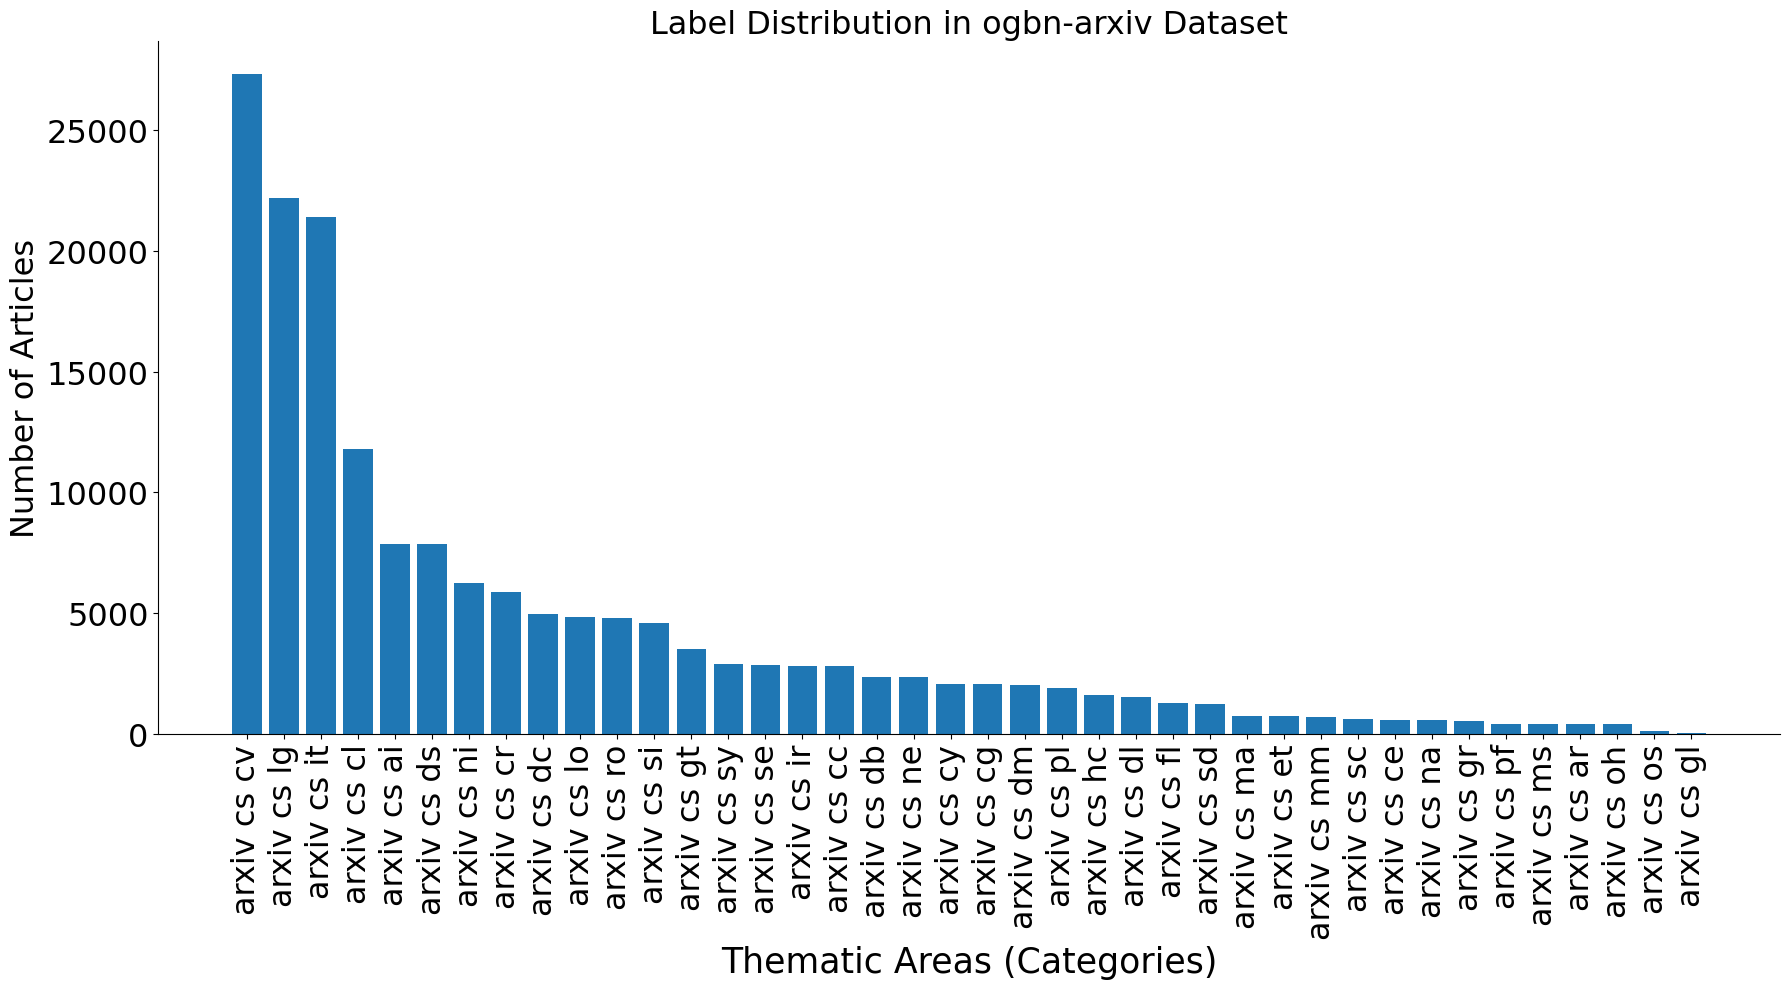

In [13]:
sorted_names, sorted_counts = zip(*sorted_named_labels)

# Plotting label distribution
plt.figure(figsize=(18, 10))
plt.bar(sorted_names, sorted_counts)
plt.xlabel("Thematic Areas (Categories)", fontsize=25)
plt.ylabel("Number of Articles", fontsize=23)
plt.title("Label Distribution in ogbn-arxiv Dataset", fontsize=23)
plt.xticks(rotation=90, fontsize=23) 
plt.yticks(fontsize=23) 
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

In [14]:
# Basic statistics of node embeddings
print("\nNode Embedding Statistics:")
print(f"  Shape of embeddings: {node_features.shape}")
print(f"  Minimum value: {node_features.min():.4f}")
print(f"  Maximum value: {node_features.max():.4f}")
print(f"  Mean: {node_features.mean():.4f}")
print(f"  Standard deviation: {node_features.std():.4f}")


Node Embedding Statistics:
  Shape of embeddings: (169343, 128)
  Minimum value: -1.3889
  Maximum value: 1.6387
  Mean: 0.0205
  Standard deviation: 0.2332


The OGBN-Arxiv dataset models a scientific citation network where each **node** represents an academic paper, and a **directed edge** from paper $A$ to paper $B$ ($A \to B$) signifies that **Paper A cites Paper B**.

---

1. Out-Degree (Citations Made)

The **Out-Degree** of a paper is the number of outgoing edges from that node.

| Metric | Scientific Meaning | Interpretation |
| :--- | :--- | :--- |
| **High Out-Degree** | The paper has a **large bibliography** (cites many other works). | The article is likely a **Review Paper** or a comprehensive survey, covering a broad spectrum of the existing literature in the field. |
| **Low Out-Degree** | The paper cites few or no other works in the network. | The article has a very **narrow scope**, is an early, **foundational work** in the dataset's timeline, or focuses primarily on novel, uncited methodologies. |

2. In-Degree (Citations Received)

The **In-Degree** of a paper is the number of incoming edges to that node.

| Metric | Scientific Meaning | Interpretation |
| :--- | :--- | :--- |
| **High In-Degree** | The paper is **cited frequently** by other works.  | The article is a **Hub of Information** or **Highly Influential**. It is considered a seminal, critical, or definitive work in the field. These nodes are key targets for prediction models. |
| **Low In-Degree (e.g., Zero)** | The paper has received few or **no citations** within the network. | The article may be **very new** (not yet cited), **low-impact**, or **isolated** within the topic clusters. |

In [15]:
labels_np = labels.squeeze()     # Numpy array (node labels/categories)

# --- Degree Calculation using numpy.bincount (Efficient) ---
out_degree = np.bincount(edge_index[0], minlength=num_nodes)
in_degree = np.bincount(edge_index[1], minlength=num_nodes)

In [16]:
df_degree = pd.DataFrame({
        'node_idx': np.arange(num_nodes),
        'in_degree': in_degree,
        'out_degree': out_degree,
        'label_idx': labels_np
    })

In [17]:
df_degree.head()

,node_idx,in_degree,out_degree,label_idx
0,0,289,2,4
1,1,1,1,5
2,2,5,9,28
3,3,2,0,8
4,4,5,1,27


In [18]:
# Merge Paper ID
df_degree = pd.merge(df_degree, node_map_df, on='node_idx', how='left')
    
# Merge Title
df_degree = pd.merge(df_degree, titleabs_df[['paper_id', 'title']], on='paper_id', how='left')

# Map Category Name
df_degree['category'] = df_degree['label_idx'].map(label_map)

# Select final columns and clean up
df_degree = df_degree[['node_idx', 'paper_id', 'category', 'title', 'in_degree', 'out_degree']]
df_degree = df_degree.rename(columns={'paper_id': 'Article_ID'})

In [19]:
df_degree.head()

,node_idx,Article_ID,category,title,in_degree,out_degree
0,0,9657784,arxiv cs cr,evasion attacks against machine learning at te...,289,2
1,1,39886162,arxiv cs dc,how hard is computing parity with noisy commun...,1,1
2,2,116214155,arxiv cs it,on the absence of the rip in real world applic...,5,9
3,3,121432379,arxiv cs ni,a promise theory perspective on data networks,2,0
4,4,231147053,arxiv cs ro,analysis of asymptotically optimal sampling ba...,5,1


In [20]:
df_degree.sort_values(by='out_degree', ascending=False).head(10)

,node_idx,Article_ID,category,title,in_degree,out_degree
72253,72253,2895896816,arxiv cs lg,deep reinforcement learning,14,436
122858,122858,2992693294,arxiv cs cl,neural machine translation a review,0,366
52991,52991,2975317124,arxiv cs lg,synthetic data for deep learning,1,322
26409,26409,3002944878,arxiv cs lg,a review on generative adversarial networks al...,1,286
29688,29688,2891004411,arxiv cs cv,recent advances in object detection in the age...,7,276
51557,51557,2963177331,arxiv cs cv,trends in integration of vision and language r...,4,226
85020,85020,2580175322,arxiv cs lg,deep reinforcement learning an overview,90,223
30293,30293,2995022099,arxiv cs lg,advances and open problems in federated learning,35,204
64792,64792,2968299681,arxiv cs cv,recent advances in deep learning for object de...,2,202
43080,43080,2890715498,arxiv cs cv,deep learning for generic object detection a s...,54,195


In [21]:
df_degree.sort_values(by='in_degree', ascending=False).head(10)

,node_idx,Article_ID,category,title,in_degree,out_degree
1353,1353,1522301498,arxiv cs lg,adam a method for stochastic optimization,13155,6
67166,67166,2949650786,arxiv cs cv,deep residual learning for image recognition,12527,21
25208,25208,1686810756,arxiv cs cv,very deep convolutional networks for large sca...,9244,21
69794,69794,2949117887,arxiv cs lg,batch normalization accelerating deep network ...,4779,7
93649,93649,2952020226,arxiv cs cv,imagenet large scale visual recognition challenge,4238,20
115359,115359,2133564696,arxiv cs cl,neural machine translation by jointly learning...,4033,11
22035,22035,2950179405,arxiv cs cv,going deeper with convolutions,3861,9
133376,133376,2953106684,arxiv cs cv,faster r cnn towards real time object detectio...,3844,25
106699,106699,2950133940,arxiv cs cl,distributed representations of words and phras...,3737,4
166425,166425,2952632681,arxiv cs cv,fully convolutional networks for semantic segm...,3407,32


3. Distribution Analysis (Histogram)

When plotting the distribution of both In-Degree and Out-Degree on a log-log scale (as done in the code), the data typically exhibits a **Power-Law Distribution** .

* **Interpretation:** This confirms that the Arxiv network is a **Scale-Free Network**. A vast majority of papers have very few citations, while a tiny minority of papers (the **hubs**) account for the majority of the connectivity and influence in the network.
* **Symmetry:** Given that the OGBN-Arxiv is often used as a projected, undirected graph, the In-Degree and Out-Degree histograms usually **overlap heavily**, showing a high degree of symmetry between the number of references made and the number received across the entire dataset structure.

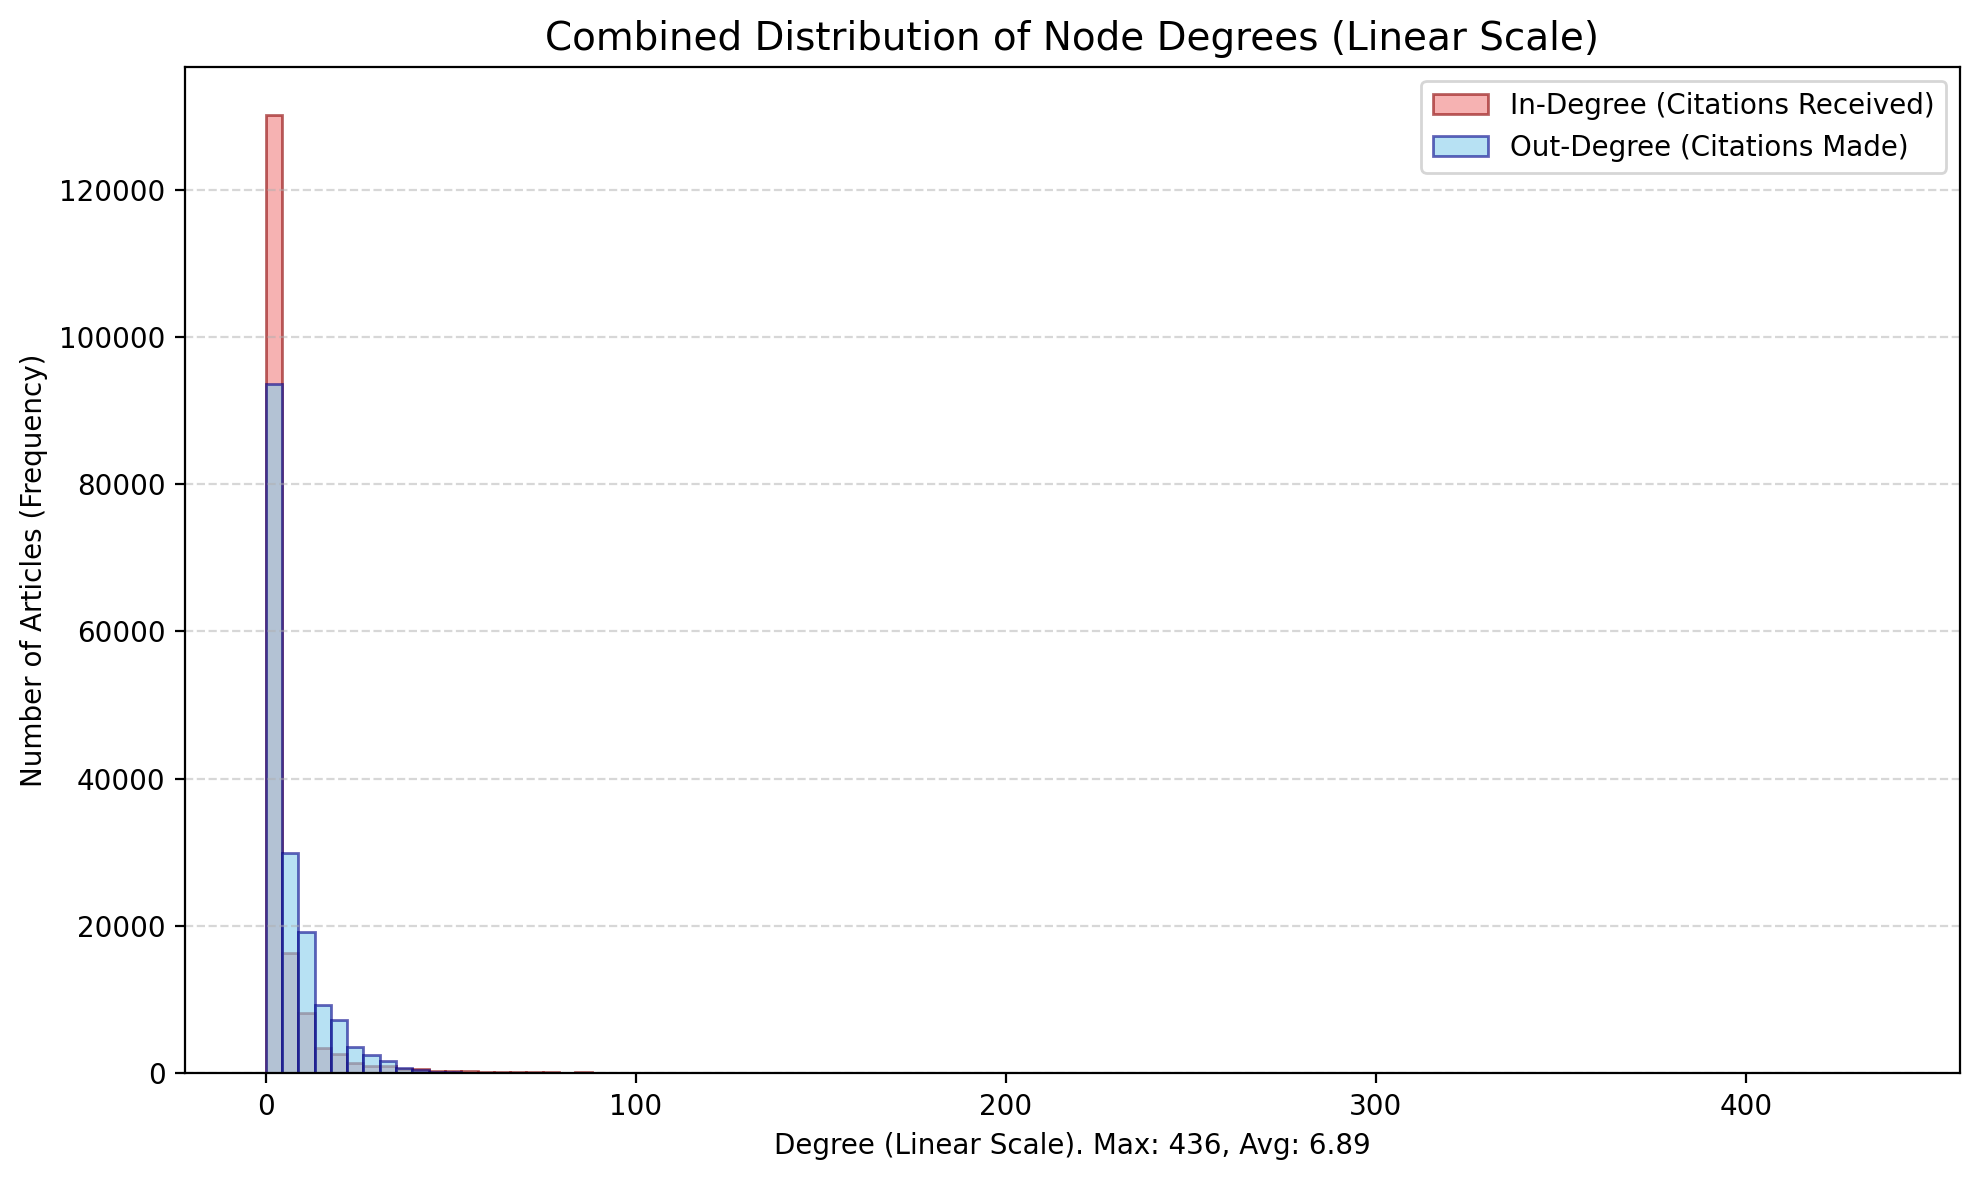

In [22]:
# --- DEGREE DATA EXTRACTION ---

out_degree_np = df_degree['out_degree'].values
in_degree_np = df_degree['in_degree'].values

# Analyze metrics
max_degree = int(np.max(out_degree_np))
avg_degree = np.mean(out_degree_np)

# Define linear bins across the range [0, max_degree]
# Usamos 100 bins uniformes para o histograma em escala linear.
bins = np.linspace(0, max_degree, 100) 

plt.figure(figsize=(10, 6), dpi=200)

# --- Combined Plotting (Linear Scale) ---

# 1. In-Degree Histogram (Citations Received)
# Note: log=True (escala logarítmica) FOI REMOVIDO para que o Eixo Y seja LINEAR.
plt.hist(in_degree_np, 
            bins=bins, 
            color='lightcoral', 
            edgecolor='darkred', 
            alpha=0.6, # Transparency to show overlap
            label='In-Degree (Citations Received)') 

# 2. Out-Degree Histogram (Citations Made)
# Note: log=True (escala logarítmica) FOI REMOVIDO para que o Eixo Y seja LINEAR.
plt.hist(out_degree_np, 
            bins=bins, 
            color='skyblue', 
            edgecolor='darkblue', 
            alpha=0.6, # Transparency
            label='Out-Degree (Citations Made)') 

# --- Final Plot Configuration ---

# Note: plt.xscale('log') FOI REMOVIDO para que o Eixo X seja LINEAR.
plt.title('Combined Distribution of Node Degrees (Linear Scale)', fontsize=14)
plt.xlabel(f'Degree (Linear Scale). Max: {max_degree}, Avg: {avg_degree:.2f}')
plt.ylabel('Number of Articles (Frequency)')
plt.legend(loc='upper right')
# Grid no eixo Y linear
plt.grid(axis='y', alpha=0.5, linestyle='--') 

plt.tight_layout()
plt.show()

Analyzing the Network Topology: Power-Law Distribution using CCDF

The code you provided generates a **Complementary Cumulative Distribution Function (CCDF)** plot for both **In-Degree** and **Out-Degree** on a **log-log scale**. This specific plot is the scientific standard for verifying if a large-scale network, like the OGBN-Arxiv citation graph, follows a **Power-Law Distribution** (i.e., is a Scale-Free Network).

1. Key Components of the Code

The code focuses on calculating the probability that a node's degree ($K$) is greater than or equal to a given value ($k$), denoted as $P(K \ge k)$.

| Code Step | Metric Calculated | Purpose |
| :--- | :--- | :--- |
| **`degree_counts`** | Frequency of each degree $k$. | Counts how many articles have exactly $k$ citations (or references). |
| **`ccdf = np.cumsum(pk[::-1])[::-1]`** | $P(K \ge k)$ | Calculates the CCDF by performing an inverse cumulative sum of the probabilities. |
| **`plt.xscale('log')` & `plt.yscale('log')`** | Log-Log Scale | Essential transformation to visualize the Power-Law. |

2. Interpretation of the Plot

If the network follows a Power-Law, the relationship between the degree $k$ and the CCDF $P(K \ge k)$ is defined as:

$$P(K \ge k) \propto k^{-(\gamma - 1)}$$

When plotted on a log-log scale, this relationship linearizes:

$$\log P(K \ge k) = -(\gamma - 1) \log k + \text{Constant}$$

**Interpretation of the straight line:**

* **Straight Line:** If the data points for In-Degree and Out-Degree fall along a **straight, descending line** on the log-log plot (especially in the tail), the network is confirmed to be **Scale-Free**. 
* **Deviation:** Any significant deviation from a straight line at high degrees might indicate the presence of a "cut-off" or an exponential decay, suggesting the network may be aging or subject to external constraints.
* **In-Degree vs. Out-Degree:** For OGBN-Arxiv, the two lines should be very close, reflecting the overall **symmetry** of the citation graph. The negative slope ($\text{Slope} = -(\gamma - 1)$) determines the fatness of the tail, confirming that high-degree nodes (hubs) are far more common than in random networks.

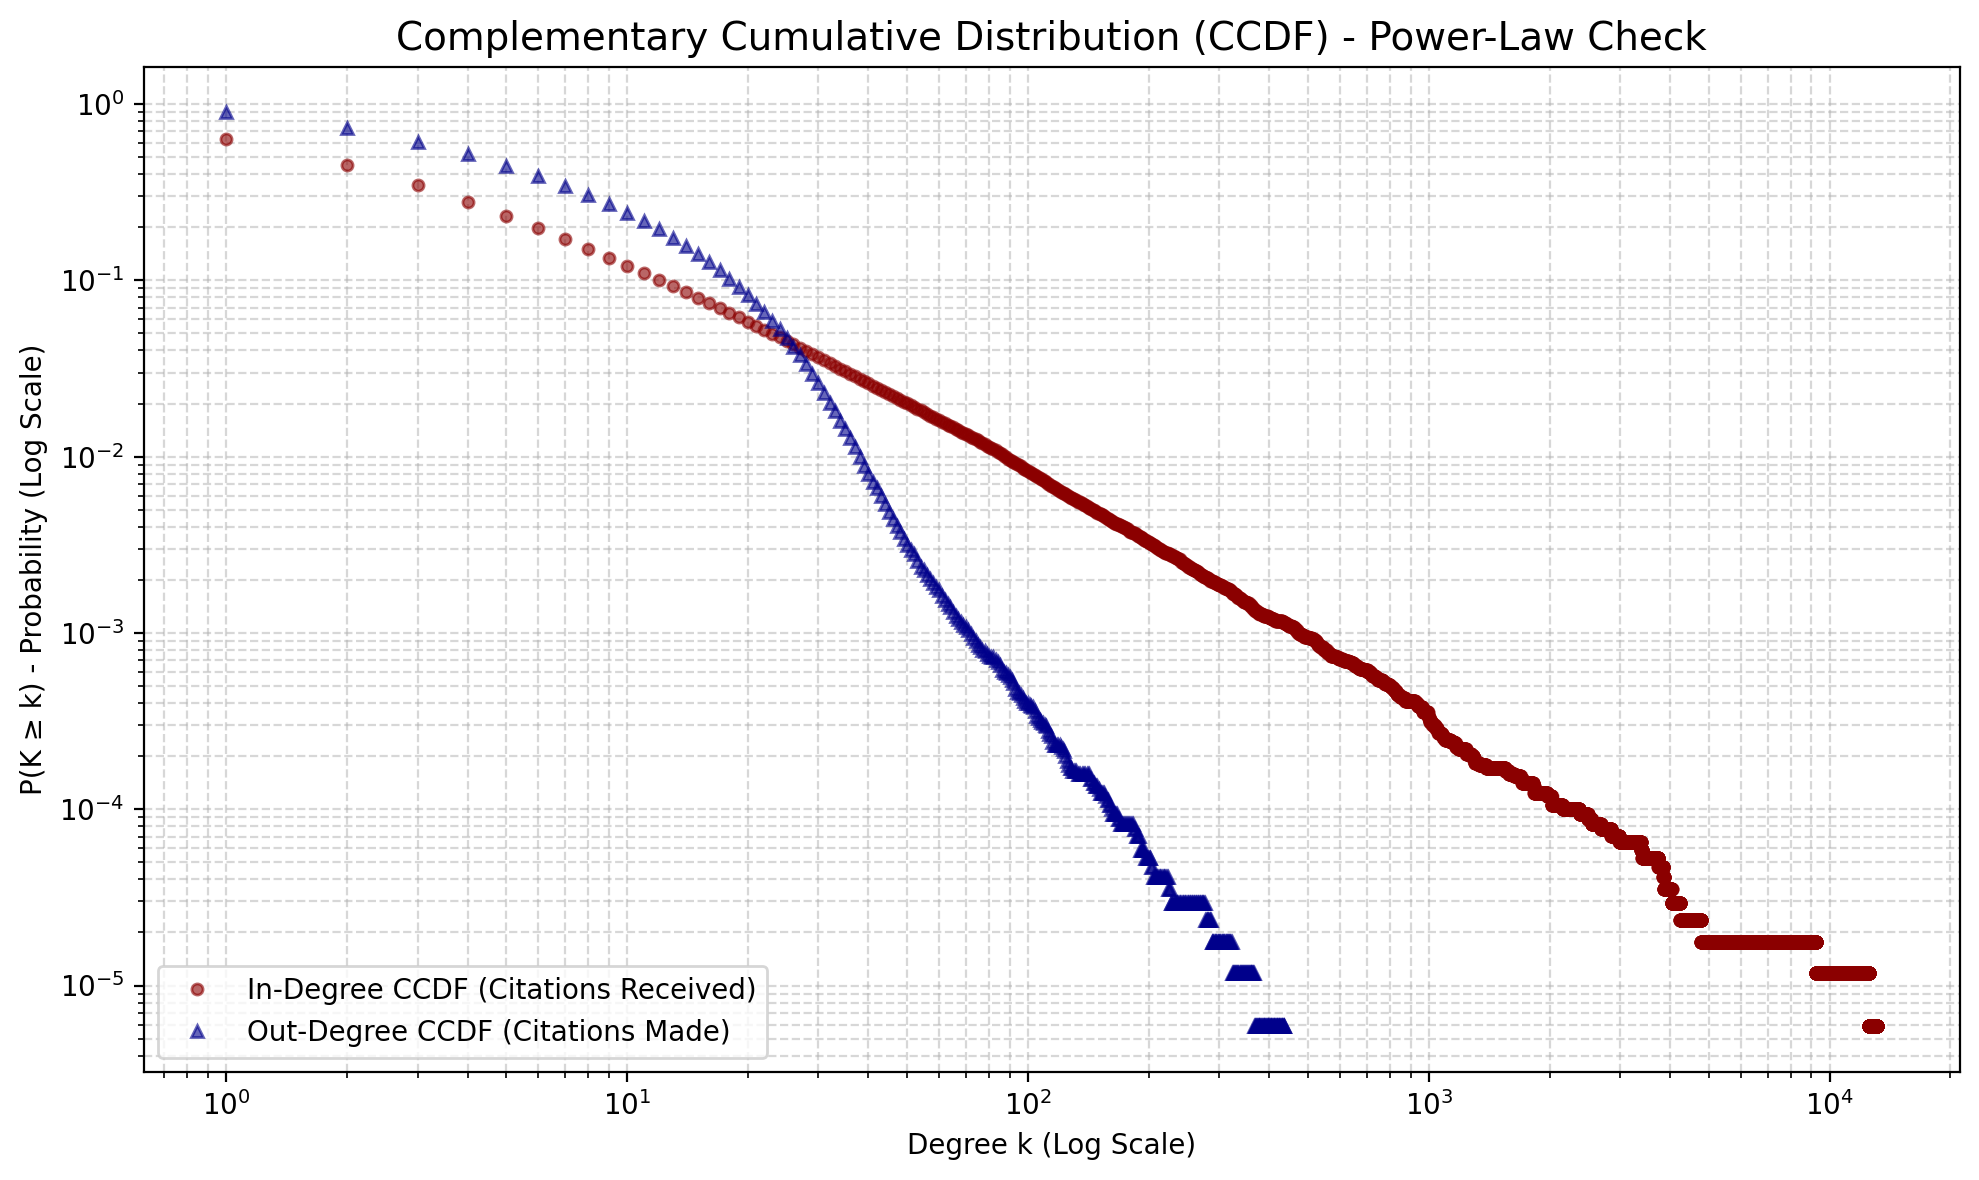

In [23]:
# --- CCDF CALCULATION LOGIC (Non-Function) ---

# Helper function to calculate the CCDF: P(K >= k).
# This logic is extracted and kept local to avoid defining a separate function.
def calculate_ccdf_data(degrees):
    """Calculates the CCDF data points."""
    # 1. Count the frequency of each degree
    degree_counts = np.bincount(degrees)
    max_k = len(degree_counts) - 1
    
    # 2. Normalize to get the Probability P(k)
    pk = degree_counts / degrees.size
    
    # 3. Calculate the CCDF (Inverse Cumulative Sum P(K >= k))
    # np.cumsum(pk[::-1])[::-1] is an efficient way to calculate this.
    ccdf = np.cumsum(pk[::-1])[::-1]
    
    # Returns degree k (excluding k=0) and the CCDF
    return np.arange(1, max_k + 1), ccdf[1:]

# --- DEGREE DATA EXTRACTION ---
out_degree_np = df_degree['out_degree'].values
in_degree_np = df_degree['in_degree'].values

# --- CALCULATE CCDF ---
k_out, ccdf_out = calculate_ccdf_data(out_degree_np)
k_in, ccdf_in = calculate_ccdf_data(in_degree_np)

# --- PLOTTING (Log-Log Scale) ---
plt.figure(figsize=(10, 6), dpi=200)

# Plot In-Degree CCDF
plt.plot(k_in, ccdf_in, 
         marker='o', markersize=4, linestyle='None', 
         color='darkred', alpha=0.6, label='In-Degree CCDF (Citations Received)')

# Plot Out-Degree CCDF
plt.plot(k_out, ccdf_out, 
         marker='^', markersize=4, linestyle='None', 
         color='darkblue', alpha=0.6, label='Out-Degree CCDF (Citations Made)')

# --- Final Plot Configuration ---
# Setting both axes to log scale confirms the Power-Law nature.
plt.xscale('log')
plt.yscale('log') # 

plt.title('Complementary Cumulative Distribution (CCDF) - Power-Law Check', fontsize=14)
plt.xlabel('Degree k (Log Scale)')
plt.ylabel('P(K ≥ k) - Probability (Log Scale)') 
plt.legend(loc='lower left')
plt.grid(which='both', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()

## Graph Visualization

In [24]:
def visualize_ego_graph(target_node_id, edge_index, labels, label_map, 
                        node2paperid, paperid2title, max_nodes=100):
    """
    Visualizes the ego-graph (subgraph) around a specific node.
    
    Parameters:
    - target_node_id: The integer index of the node to visualize.
    - edge_index: The edge index tensor/array of the graph (2, num_edges).
    - labels: Array of node labels.
    - label_map: Dictionary mapping label indices to category names.
    - node2paperid: Dictionary mapping node indices to MAG Paper IDs.
    - paperid2title: Dictionary mapping MAG Paper IDs to Titles.
    - max_nodes: Maximum number of nodes to display (to avoid clutter).
    """
    
    # 1. Calculate Degrees (Connections)
    src, dst = edge_index[0], edge_index[1]
    
    in_degree = np.sum(dst == target_node_id)   # How many cite this paper
    out_degree = np.sum(src == target_node_id)  # How many this paper cites
    total_connections = in_degree + out_degree

    print(f"--- Node Analysis ---")
    print(f"Target Node: {target_node_id}")
    print(f"In-Degree (Citations Received): {in_degree}")
    print(f"Out-Degree (References Made): {out_degree}")
    print(f"Total Connections: {total_connections}")

    # 2. Subgraph Sampling
    # Find neighbors (either source or destination is the target)
    neighbor_mask = (src == target_node_id) | (dst == target_node_id)
    
    # Get unique neighbors
    direct_neighbors = np.unique(np.concatenate((src[neighbor_mask], dst[neighbor_mask])))
    
    # Remove the target node itself from neighbors list to handle sampling
    direct_neighbors = direct_neighbors[direct_neighbors != target_node_id]
    
    # If too many neighbors, sample randomly
    if len(direct_neighbors) > (max_nodes - 1):
        rng = np.random.default_rng(42)
        direct_neighbors = rng.choice(direct_neighbors, size=(max_nodes - 1), replace=False)
        print(f"Note: Subgraph sampled to {max_nodes} nodes (original neighbors: {len(direct_neighbors) + 1})")

    # Combine target and neighbors
    nodes_in_subgraph = np.append(direct_neighbors, target_node_id)
    
    # Filter edges to keep only those connecting nodes within this subgraph
    mask_sub = np.isin(src, nodes_in_subgraph) & np.isin(dst, nodes_in_subgraph)
    subset_src = src[mask_sub]
    subset_dst = dst[mask_sub]

    # 3. Retrieve Metadata
    try:
        center_mag_id = node2paperid[target_node_id]
        center_title = paperid2title.get(center_mag_id, "Title not found in mapping")
    except KeyError:
        center_title = "Metadata not found"
        
    center_cat_idx = labels[target_node_id].item()
    center_category = label_map[center_cat_idx]

    # 4. Prepare NetworkX Graph
    G = nx.DiGraph()
    G.add_nodes_from(nodes_in_subgraph)
    G.add_edges_from(list(zip(subset_src, subset_dst)))

    # Colors setup (using a professional palette)
    subgraph_labels = labels[nodes_in_subgraph].flatten()
    unique_sub_labels = np.unique(subgraph_labels)
    cmap = plt.get_cmap("tab10") 
    color_map_dict = {label: cmap(i % 10) for i, label in enumerate(unique_sub_labels)}
    
    node_colors = [color_map_dict[labels[n].item()] for n in G.nodes()]
    
    # Sizes: Target node is larger
    node_sizes = [1500 if n == target_node_id else 300 for n in G.nodes()]

    # 5. Plotting
    plt.figure(figsize=(16, 10), facecolor='white', dpi=200)
    
    # Layout with repulsion (k)
    pos = nx.spring_layout(G, seed=42, k=1.5, iterations=100)

    # Draw Edges (Curved)
    nx.draw_networkx_edges(G, pos, 
                           edge_color='lightgray', 
                           alpha=0.6, 
                           arrows=True, 
                           arrowstyle='-|>', 
                           arrowsize=15, 
                           width=1.5,
                           connectionstyle="arc3,rad=0.1")

    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, 
                           nodelist=G.nodes(),
                           node_size=node_sizes, 
                           node_color=node_colors, 
                           alpha=0.9,
                           edgecolors='white', 
                           linewidths=2)

    # Draw Label for Target Node Only
    nx.draw_networkx_labels(G, pos, labels={target_node_id: str(target_node_id)}, 
                            font_size=12, font_weight='bold', font_color='white')

    # 6. Information Card (Text Box)
    info_text = (f"NODE ID: {target_node_id}\n"
                 f"IN-DEGREE: {in_degree}\n"
                 f"OUT-DEGREE: {out_degree}\n"
                 f"CATEGORY: {center_category}\n"
                 f"{'-'*25}\n"
                 f"TITLE:\n{textwrap.fill(center_title, width=35)}")

    plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes,
             fontsize=16, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.8', facecolor='#f8f9fa', alpha=0.9, edgecolor='#dee2e6'))

    # 7. Legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label_map[lbl],
                              markerfacecolor=color, markersize=10)
                       for lbl, color in color_map_dict.items()]

    plt.legend(handles=legend_elements, title="Research Fields", 
               loc='lower right', frameon=True, framealpha=0.9, fontsize=16)

    plt.title(f"Ego-Graph Visualization: Node {target_node_id}", fontsize=18, weight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

--- Selection Summary ---
Top 3 Most Cited Nodes: [ 1353 67166 25208] (Citations: [13155 12527  9244])
Least Cited Node: 84477 (Citations: 1)
-------------------------

Generating Graph for Node 1353 (#1 Most Cited)...
--- Node Analysis ---
Target Node: 1353
In-Degree (Citations Received): 13155
Out-Degree (References Made): 6
Total Connections: 13161
Note: Subgraph sampled to 100 nodes (original neighbors: 100)


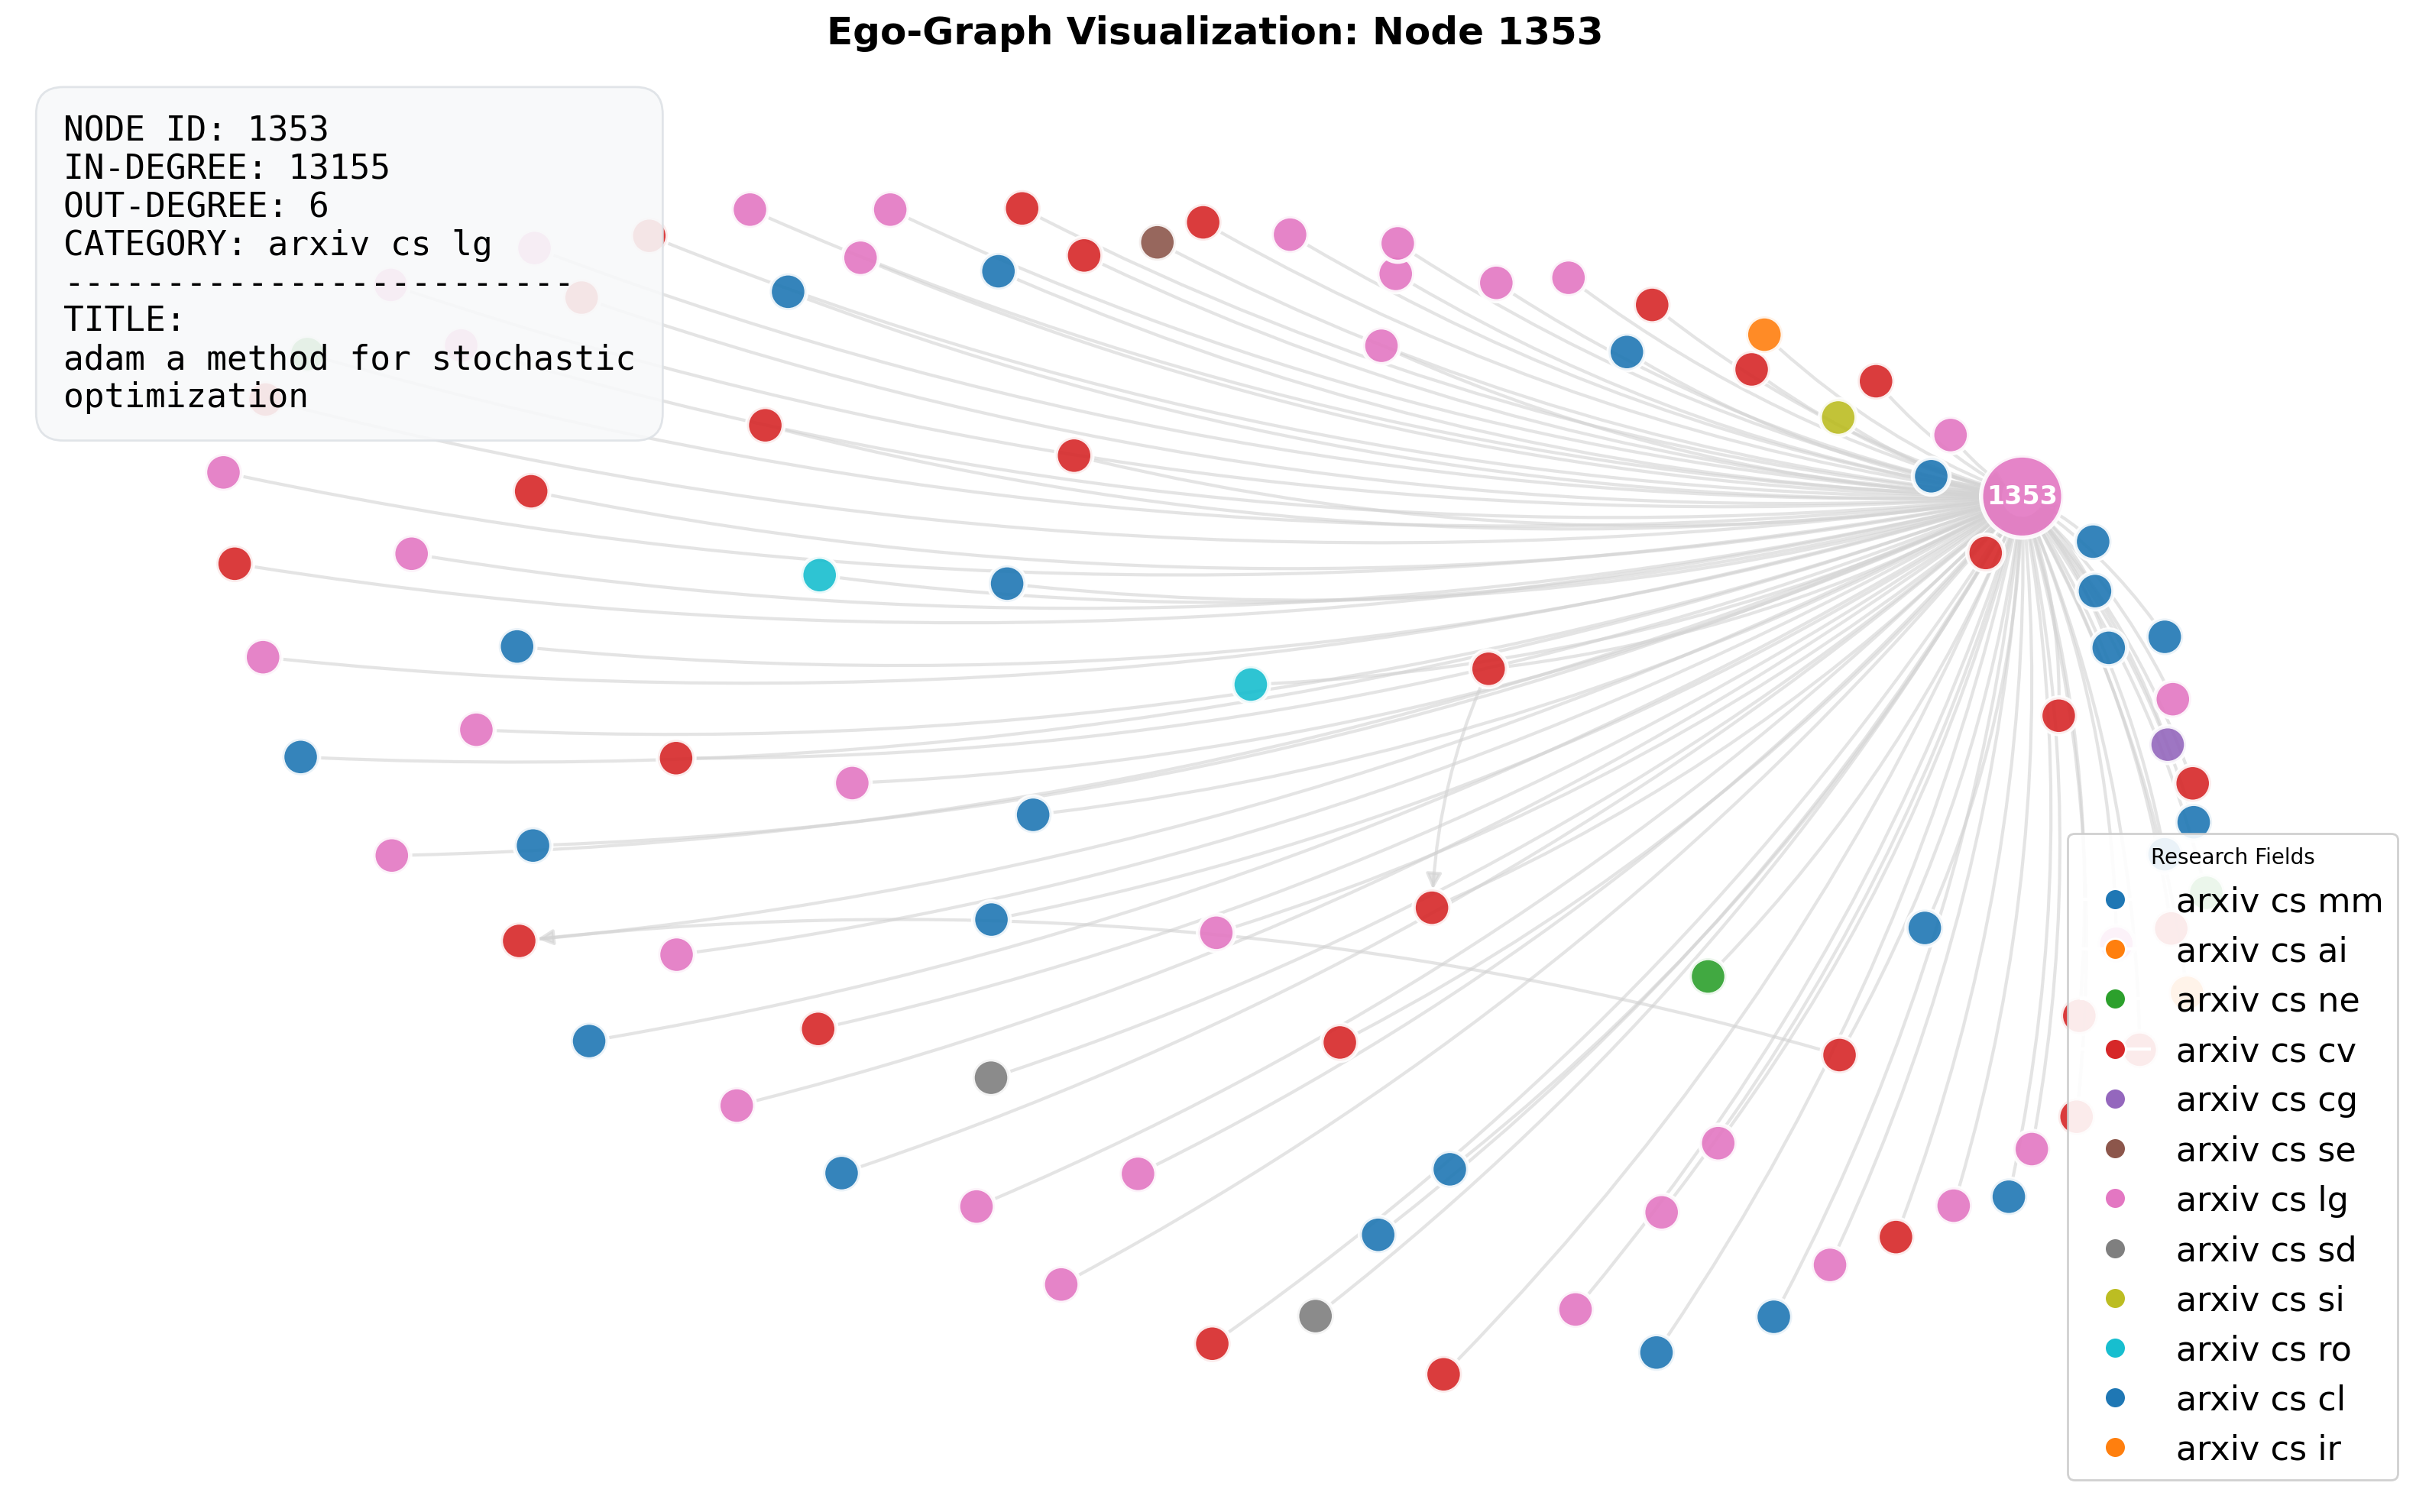

Generating Graph for Node 67166 (#2 Most Cited)...
--- Node Analysis ---
Target Node: 67166
In-Degree (Citations Received): 12527
Out-Degree (References Made): 21
Total Connections: 12548
Note: Subgraph sampled to 100 nodes (original neighbors: 100)


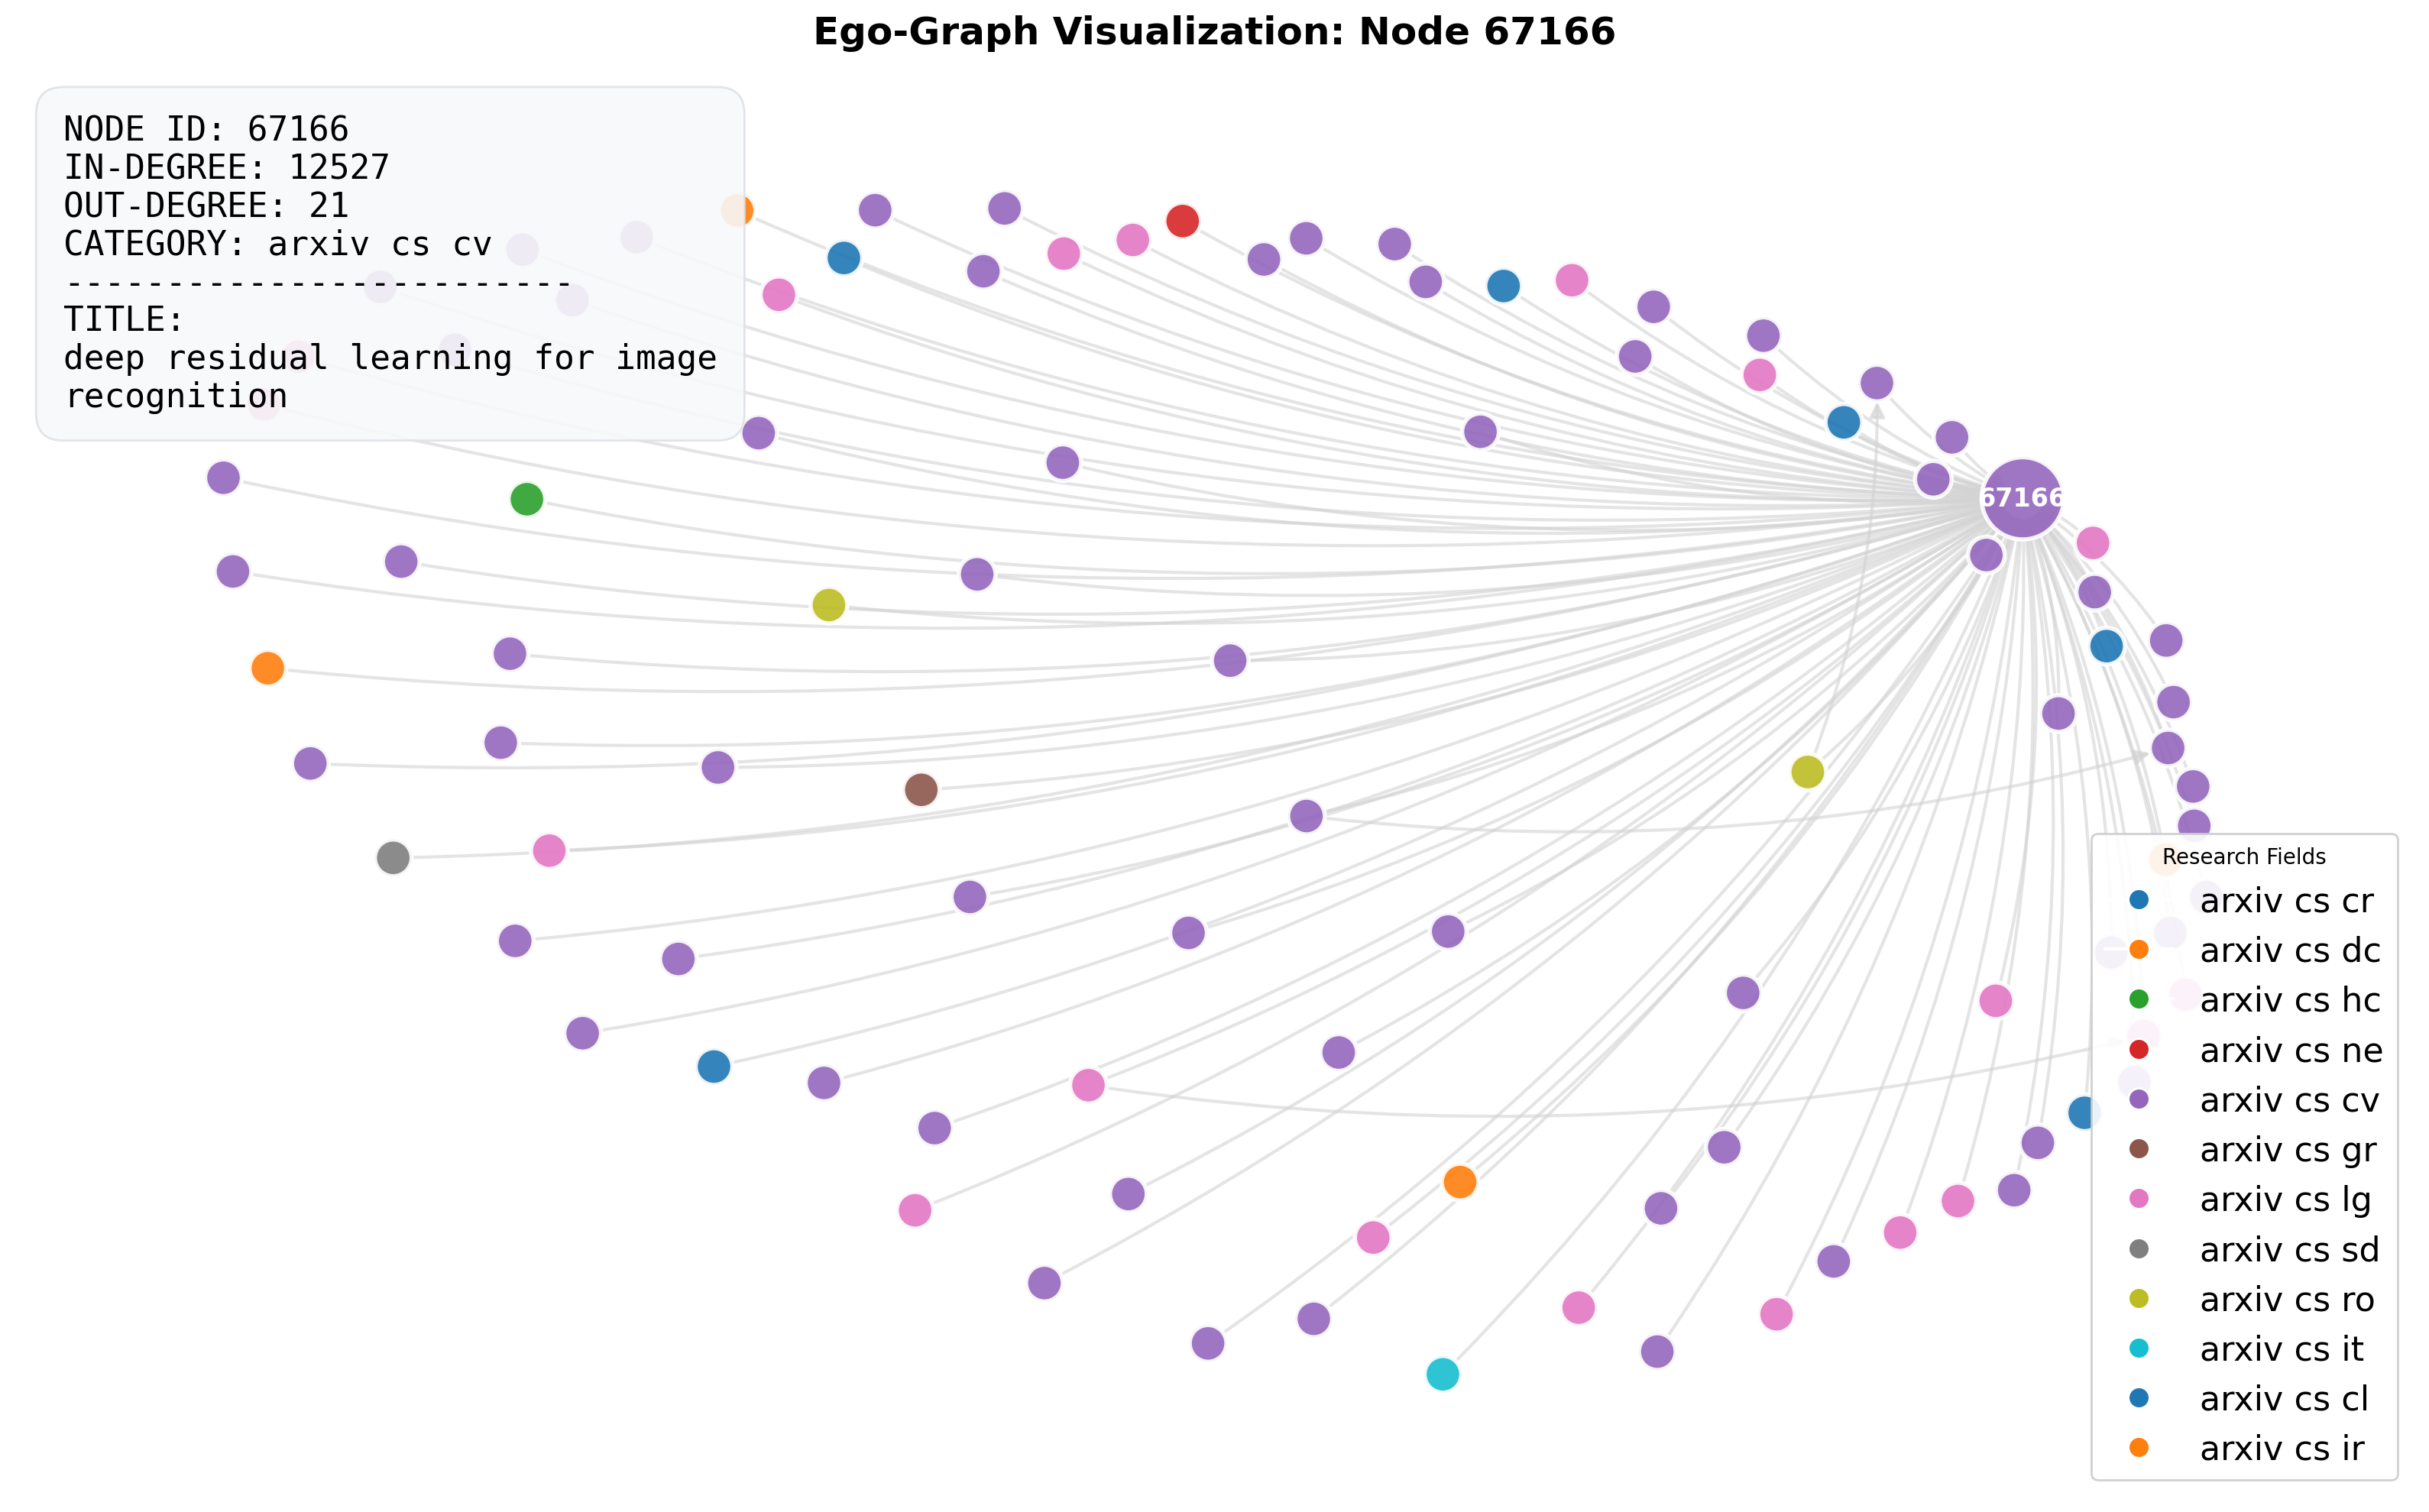

Generating Graph for Node 25208 (#3 Most Cited)...
--- Node Analysis ---
Target Node: 25208
In-Degree (Citations Received): 9244
Out-Degree (References Made): 21
Total Connections: 9265
Note: Subgraph sampled to 100 nodes (original neighbors: 100)


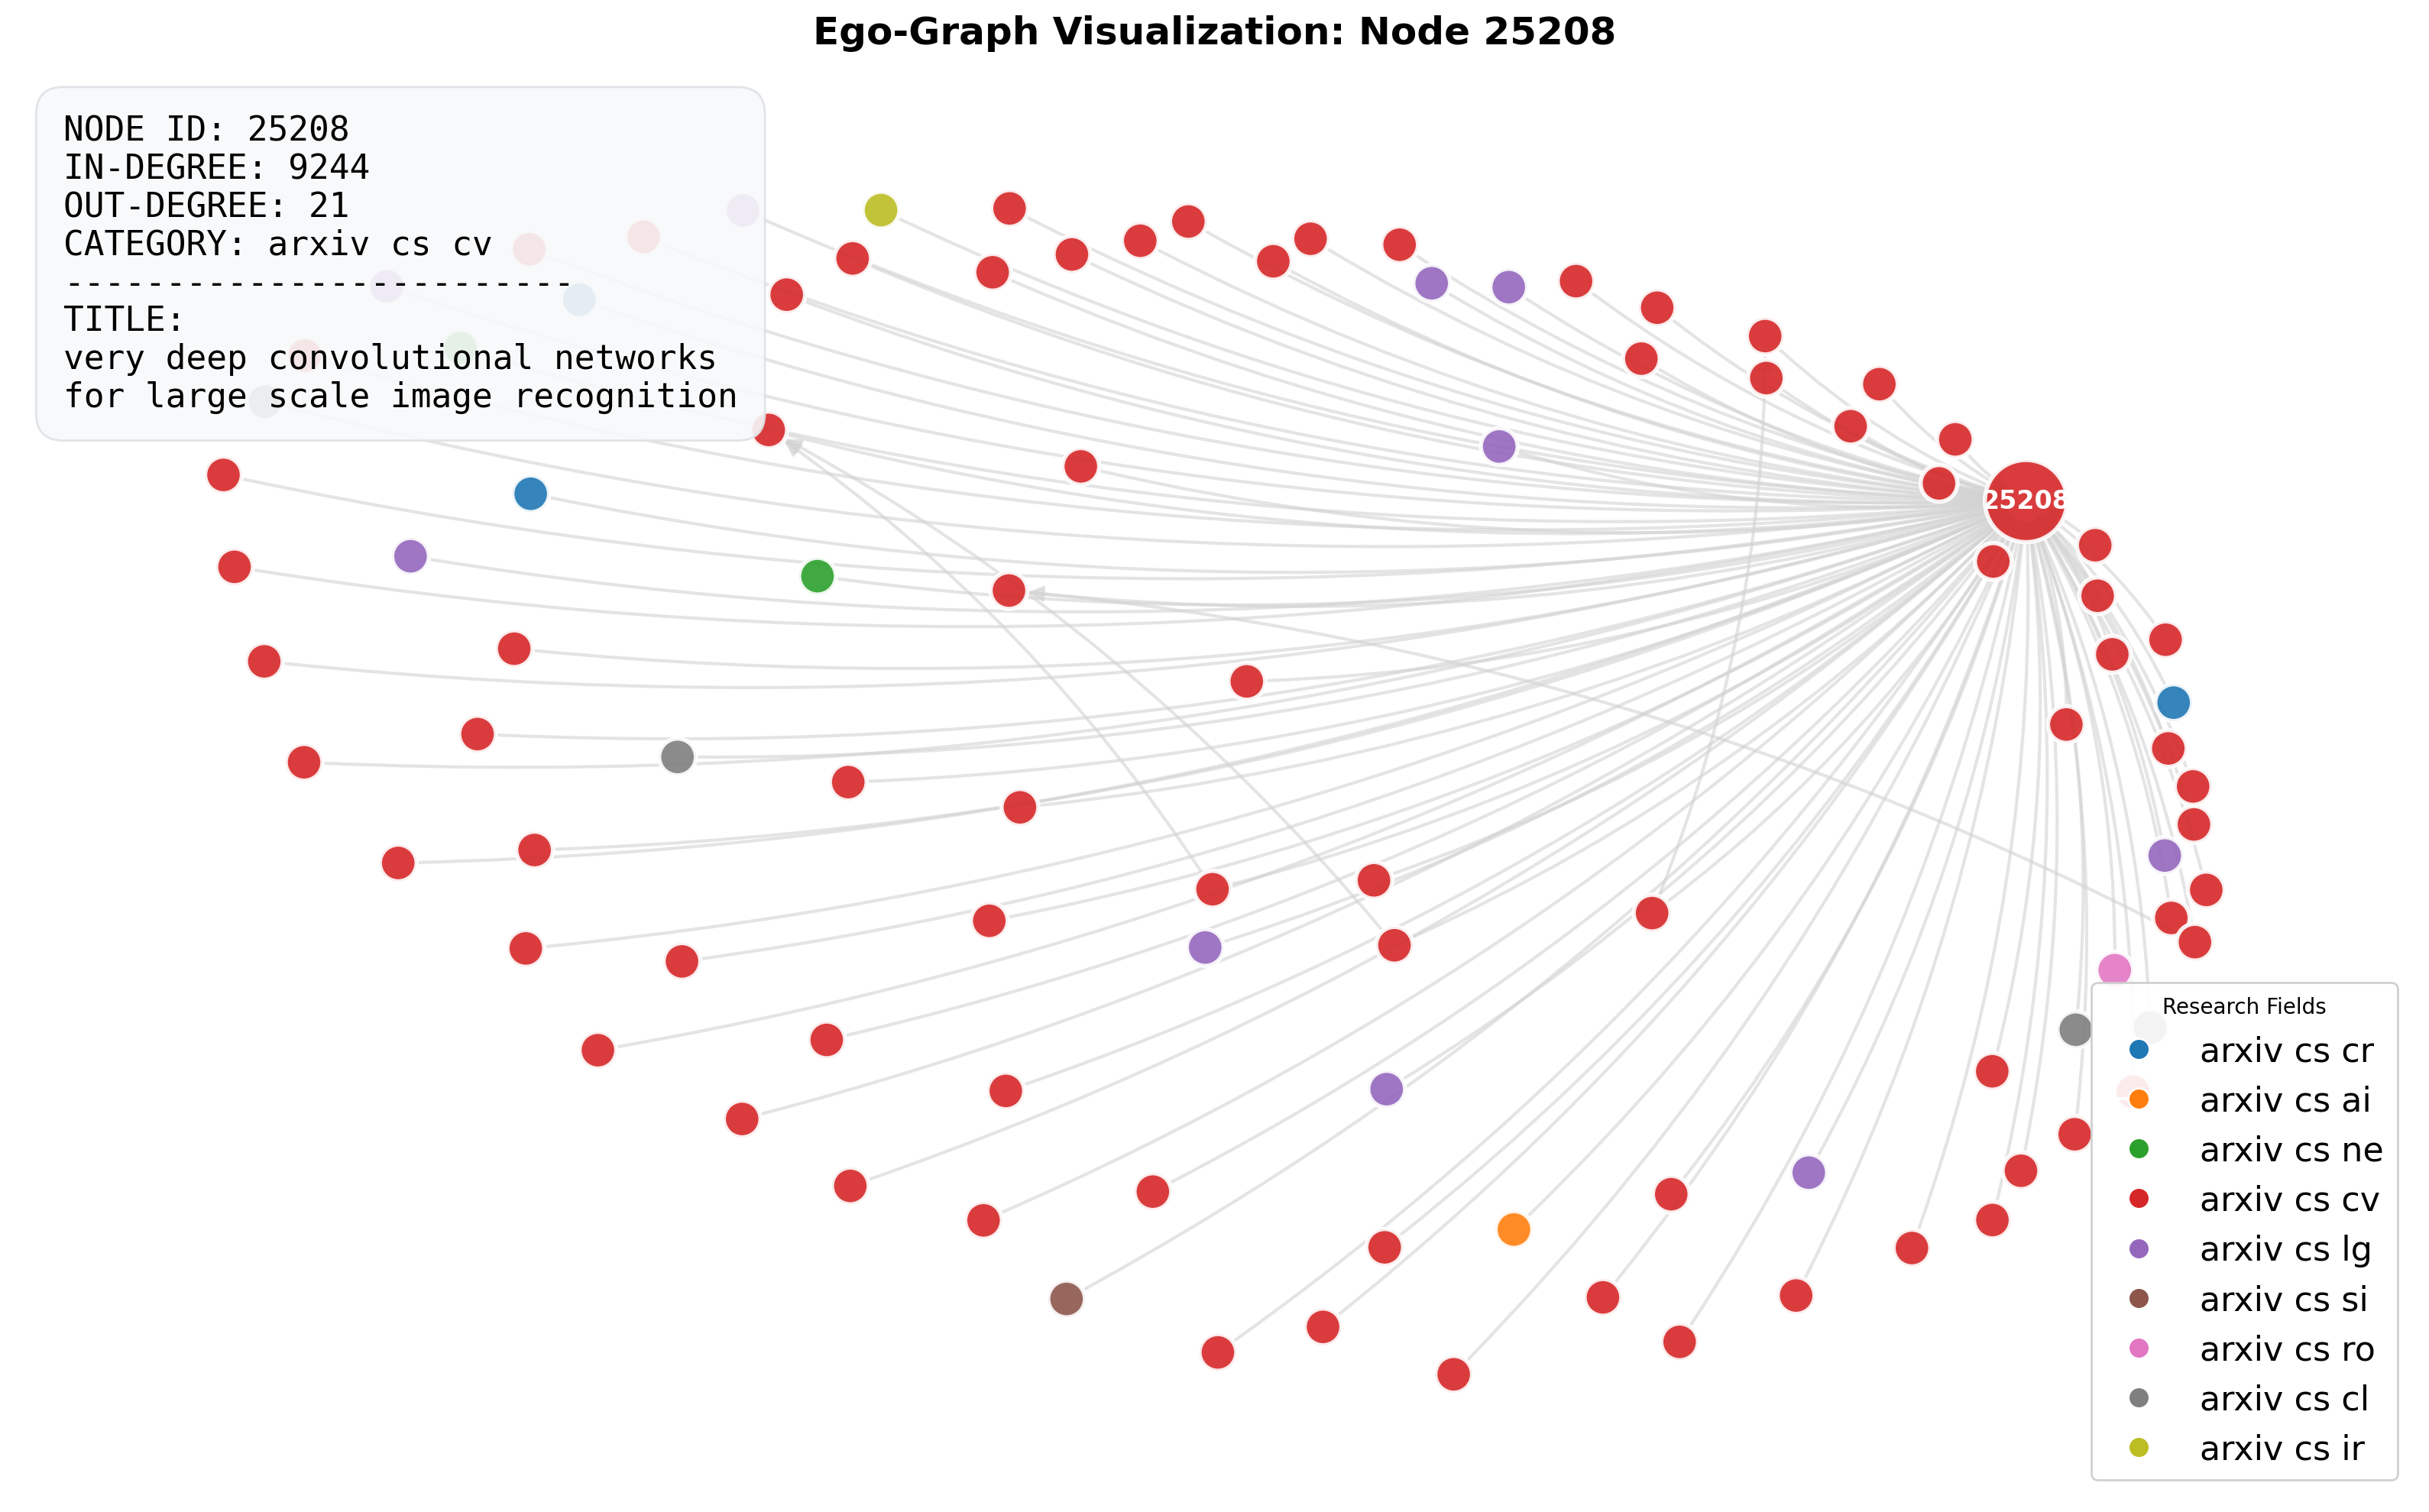

Generating Graph for Node 84477 (Least Cited (Example))...
--- Node Analysis ---
Target Node: 84477
In-Degree (Citations Received): 1
Out-Degree (References Made): 5
Total Connections: 6


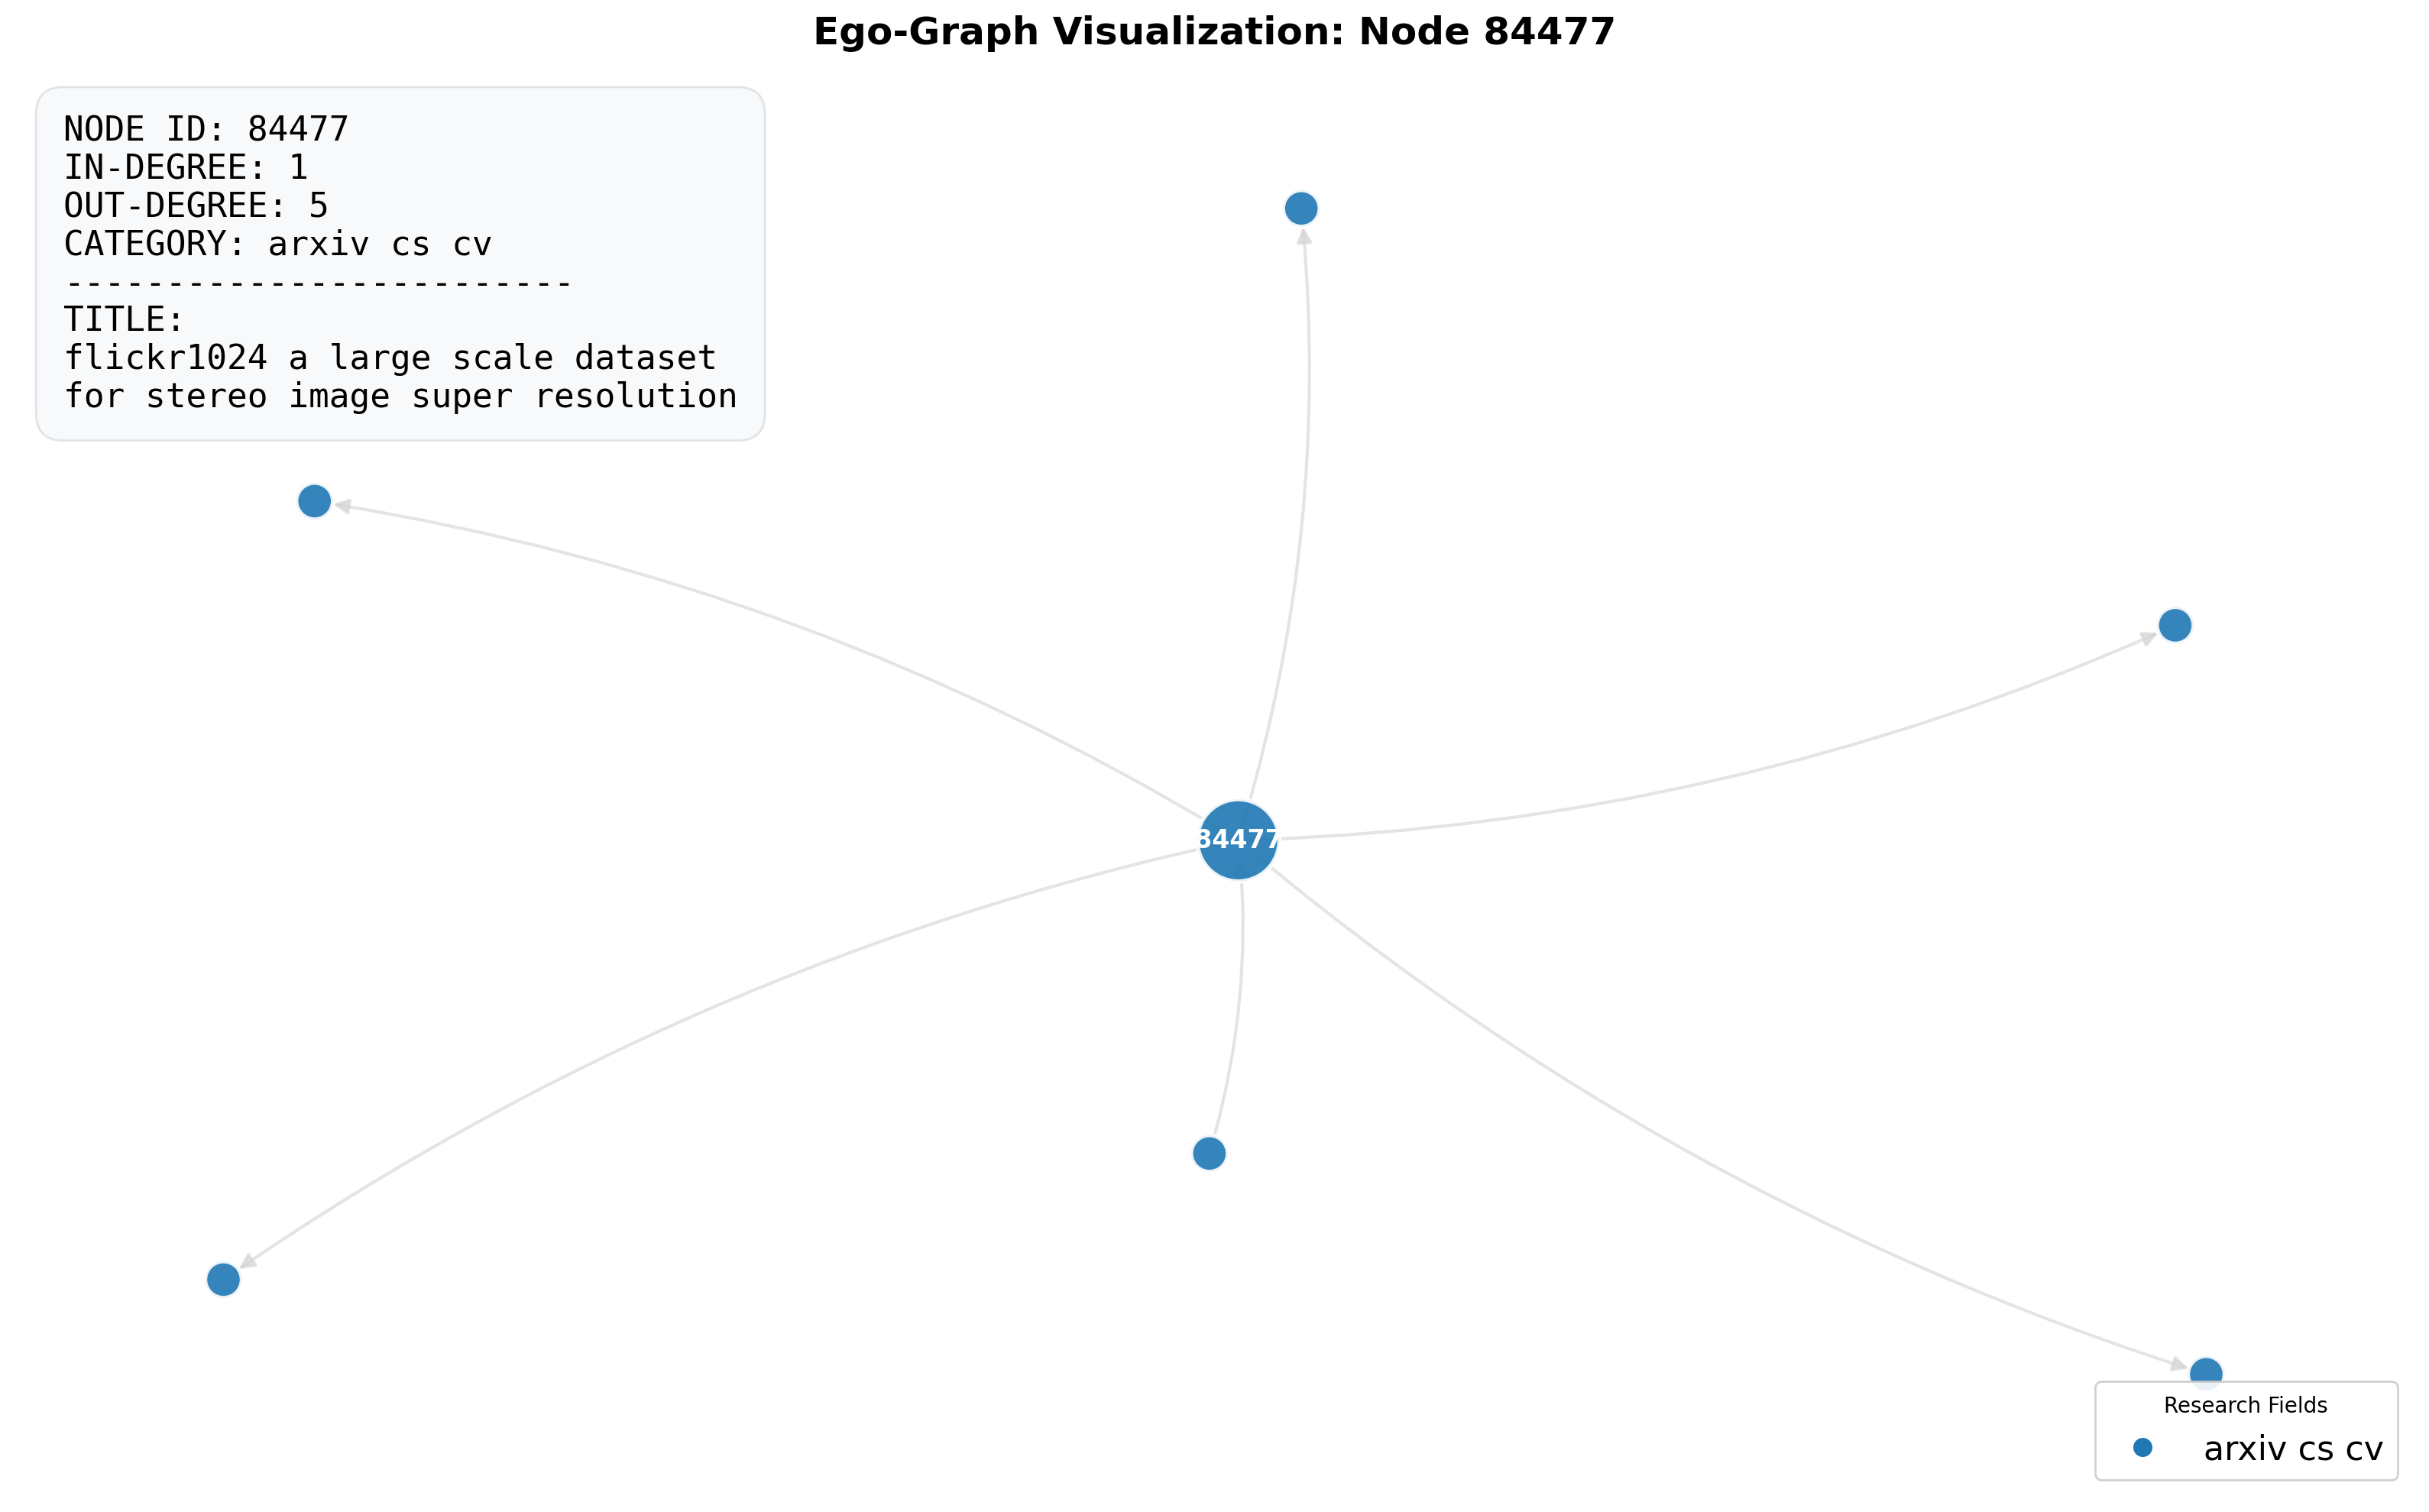

In [25]:
# --- 1. Calculate In-Degrees for all nodes ---
src, dst = edge_index[0], edge_index[1]

# unique_dst: Node IDs that receive at least one citation
# counts: How many citations they received
unique_dst, counts = np.unique(dst, return_counts=True)

# --- 2. Sort and Select Targets ---
# argsort returns the indices that would sort the array
sorted_indices = np.argsort(counts)

# Top 3 Nodes (Highest In-Degree)
# We take the last 3 indices and reverse them to have: 1st, 2nd, 3rd
top_3_indices = sorted_indices[-3:][::-1]
top_3_nodes = unique_dst[top_3_indices]
top_3_counts = counts[top_3_indices]

# Bottom 1 Node (Lowest In-Degree among cited papers)
# We take the first index (usually has 1 citation)
bottom_index = sorted_indices[0]
bottom_node = unique_dst[bottom_index]
bottom_count = counts[bottom_index]

# --- 3. Execute Visualization Loop ---

print(f"--- Selection Summary ---")
print(f"Top 3 Most Cited Nodes: {top_3_nodes} (Citations: {top_3_counts})")
print(f"Least Cited Node: {bottom_node} (Citations: {bottom_count})")
print(f"-------------------------\n")

# List of targets to visualize
targets = list(top_3_nodes) + [bottom_node]
descriptions = ["#1 Most Cited", "#2 Most Cited", "#3 Most Cited", "Least Cited (Example)"]

for node_id, desc in zip(targets, descriptions):
    print(f"Generating Graph for Node {node_id} ({desc})...")
    
    visualize_ego_graph(
        target_node_id=node_id, 
        edge_index=edge_index, 
        labels=labels, 
        label_map=label_map, 
        node2paperid=node2paperid, 
        paperid2title=paperid2title,
        max_nodes=100 
    )

In [26]:
def visualize_complete_interactive(target_node_id, edge_index, labels, label_map, 
                                   node2paperid, paperid2title, max_nodes=40):
    """
    Generates an interactive Plotly visualization for the ego-graph of a specific node.
    Features:
    - Directed edges with arrows.
    - Nodes colored by subject category.
    - Hover tooltips with metadata (ID, Category, Title).
    - Dynamic title showing the paper name.
    """
    
    # --- 1. Data Preparation ---
    src, dst = edge_index[0], edge_index[1]
    
    # Calculate degrees (for display info)
    in_degree = np.sum(dst == target_node_id)
    out_degree = np.sum(src == target_node_id)
    
    # Identify direct neighbors (source or destination is the target)
    neighbor_mask = (src == target_node_id) | (dst == target_node_id)
    direct_neighbors = np.unique(np.concatenate((src[neighbor_mask], dst[neighbor_mask])))
    
    # Remove the target node itself from the neighbor list
    direct_neighbors = direct_neighbors[direct_neighbors != target_node_id]
    
    # Sampling (if too many neighbors, pick a random subset to avoid clutter)
    if len(direct_neighbors) > (max_nodes - 1):
        rng = np.random.default_rng(42)
        direct_neighbors = rng.choice(direct_neighbors, size=(max_nodes - 1), replace=False)

    # Combine target and sampled neighbors
    nodes_in_subgraph = np.append(direct_neighbors, target_node_id)
    
    # IMPORTANT: Filter ALL edges connecting ANY nodes within this subgraph
    # This ensures connections between neighbors (A -> B) are shown, not just A -> Center
    mask_sub = np.isin(src, nodes_in_subgraph) & np.isin(dst, nodes_in_subgraph)
    subset_src = src[mask_sub]
    subset_dst = dst[mask_sub]

    # Create NetworkX Graph (used for layout calculation)
    G = nx.DiGraph()
    G.add_nodes_from(nodes_in_subgraph)
    G.add_edges_from(list(zip(subset_src, subset_dst)))
    
    # Calculate Layout (X, Y positions)
    # 'k' controls the distance between nodes; higher k = more spread out
    pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)

    # --- 2. Target Node Metadata (For the Chart Title) ---
    try:
        center_mag_id = node2paperid[target_node_id]
        center_title_full = paperid2title.get(center_mag_id, "Title not found")
    except KeyError:
        center_title_full = "Metadata not found"
    
    # Truncate title for the chart header if it's too long
    short_title = textwrap.shorten(center_title_full, width=60, placeholder="...")

    # --- 3. Visual Construction ---

    # A. Edge Trace (The lines themselves)
    # We draw the lines explicitly so they appear even if annotations fail
    edge_x = []
    edge_y = []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x.extend([x0, x1, None]) # None adds a break in the line
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.8, color='#888888'), # Thin gray line
        hoverinfo='none',
        mode='lines'
    )

    # B. Annotations (Arrows)
    # Plotly doesn't do directed lines easily, so we add annotations on top of the lines
    annotations = []
    for source, target in G.edges():
        x0, y0 = pos[source]
        x1, y1 = pos[target]
        annotations.append(dict(
            ax=x0, ay=y0, axref='x', ayref='y', # Tail coordinates
            x=x1, y=y1, xref='x', yref='y',     # Head coordinates
            showarrow=True,
            arrowhead=2, 
            arrowsize=1,
            arrowwidth=0.8,
            arrowcolor='#666666',
            opacity=0.6
        ))

    # C. Nodes (Markers)
    node_x, node_y, node_text = [], [], []
    node_bg_color = []
    node_size = []
    line_width, line_color = [], []

    # Color setup: Map categories to a distinct color palette
    unique_labels_in_subgraph = np.unique(labels[nodes_in_subgraph])
    palette = px.colors.qualitative.Dark24 # High contrast palette
    category_to_color = {lbl: palette[i % len(palette)] for i, lbl in enumerate(unique_labels_in_subgraph)}

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        
        # Retrieve Metadata for Hover
        try:
            mag_id = node2paperid[node]
            title = paperid2title.get(mag_id, "Title not found")
        except KeyError:
            title = "Metadata not found"
        
        # Wrap long titles for the tooltip
        wrapped_title = "<br>".join(textwrap.wrap(title, width=50))
        cat_idx = labels[node].item()
        category_name = label_map[cat_idx]
        
        # HTML Tooltip content
        # Using underscores as a separator because <hr> acts weird in some Plotly renderers
        info = (f"<b>ID:</b> {node} | <b>Cat:</b> {category_name}<br>"
                f"________________________________<br>" 
                f"{wrapped_title}")
        node_text.append(info)
        
        # Styling based on node type
        color = category_to_color[cat_idx]
        
        if node == target_node_id:
            # Center Node: Bigger, thick black border
            node_bg_color.append(color) 
            node_size.append(35) 
            line_width.append(3)
            line_color.append('black')
        else:
            # Neighbor Nodes: Smaller, white border
            node_bg_color.append(color)
            node_size.append(15)
            line_width.append(1)
            line_color.append('white')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            color=node_bg_color,
            size=node_size,
            line=dict(width=line_width, color=line_color),
            opacity=1
        )
    )

    # --- 4. Final Figure Assembly ---
    fig = go.Figure(data=[edge_trace, node_trace], # Order matters: edges behind, nodes in front
             layout=go.Layout(
                # Dynamic Title
                title=dict(
                    text=f"<b>{short_title}</b><br>" \
                         f"<span style='font-size:14px;color:grey'>Node ID: {target_node_id} | In-Degree: {in_degree} | Out-Degree: {out_degree}</span>",
                    x=0.05, 
                    y=0.95,
                    font=dict(size=18)
                ),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=20,r=20,t=90), # Top margin increased for title
                annotations=annotations, 
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                plot_bgcolor='white'
             ))

    fig.show()

In [27]:
# --- 1. Calculate In-Degrees for all nodes ---
src, dst = edge_index[0], edge_index[1]

# unique_dst: Node IDs that receive at least one citation
# counts: How many citations they received
unique_dst, counts = np.unique(dst, return_counts=True)

# --- 2. Sort and Select Targets ---
# argsort returns the indices that would sort the array
sorted_indices = np.argsort(counts)

# Top 3 Nodes (Highest In-Degree)
# We take the last 3 indices and reverse them to have: 1st, 2nd, 3rd
top_3_indices = sorted_indices[-3:][::-1]
top_3_nodes = unique_dst[top_3_indices]
top_3_counts = counts[top_3_indices]

# Bottom 1 Node (Lowest In-Degree among cited papers)
# We take the first index (usually has 1 citation)
bottom_index = sorted_indices[0]
bottom_node = unique_dst[bottom_index]
bottom_count = counts[bottom_index]

# --- 3. Execute Visualization Loop ---

print(f"--- Selection Summary ---")
print(f"Top 3 Most Cited Nodes: {top_3_nodes} (Citations: {top_3_counts})")
print(f"Least Cited Node: {bottom_node} (Citations: {bottom_count})")
print(f"-------------------------\n")

# List of targets to visualize
targets = list(top_3_nodes) + [bottom_node]
descriptions = ["#1 Most Cited", "#2 Most Cited", "#3 Most Cited", "Least Cited (Example)"]

for node_id, desc in zip(targets, descriptions):
    print(f"Generating Graph for Node {node_id} ({desc})...")
    
    visualize_complete_interactive(
        target_node_id=node_id, 
        edge_index=edge_index, 
        labels=labels, 
        label_map=label_map, 
        node2paperid=node2paperid, 
        paperid2title=paperid2title,
        max_nodes=40 # You can adjust this if the top nodes are too cluttered
    )

--- Selection Summary ---
Top 3 Most Cited Nodes: [ 1353 67166 25208] (Citations: [13155 12527  9244])
Least Cited Node: 84477 (Citations: 1)
-------------------------

Generating Graph for Node 1353 (#1 Most Cited)...


Generating Graph for Node 67166 (#2 Most Cited)...


Generating Graph for Node 25208 (#3 Most Cited)...


Generating Graph for Node 84477 (Least Cited (Example))...
